# An Introduction to JAX

----

#### Chase Coleman and John Stachurski

#### Prepared for the QuantEcon ICD Workshop (March 2024)

----


This lecture provides a short introduction to [Google JAX](https://github.com/google/jax).

What GPUs do we have access to?

In [1]:
!nvidia-smi

Tue Mar 26 07:26:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A2000 8GB Lap...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P0               9W /  35W |     12MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## JAX as a NumPy Replacement


One way to use JAX is as a plug-in NumPy replacement. Let's look at the
similarities and differences.

### Similarities


The following import is standard, replacing `import numpy as np`:

In [2]:
import jax
import jax.numpy as jnp

Now we can use `jnp` in place of `np` for the usual array operations:

In [3]:
a = jnp.asarray((1.0, 3.2, -1.5))

In [4]:
print(a)

[ 1.   3.2 -1.5]


In [5]:
print(jnp.sum(a))

2.6999998


In [6]:
print(jnp.mean(a))

0.9


In [7]:
print(jnp.dot(a, a))

13.490001


In [8]:
print(a @ a)  # Equivalent

13.490001


However, the array object `a` is not a NumPy array:

In [9]:
a

Array([ 1. ,  3.2, -1.5], dtype=float32)

In [10]:
type(a)

jaxlib.xla_extension.ArrayImpl

Even scalar-valued maps on arrays return JAX arrays.

In [11]:
jnp.sum(a)

Array(2.6999998, dtype=float32)

JAX arrays are also called "device arrays," where term "device" refers to a
hardware accelerator (GPU or TPU).

(In the terminology of GPUs, the "host" is the machine that launches GPU operations, while the "device" is the GPU itself.)



Operations on higher dimensional arrays are also similar to NumPy:

In [12]:
A = jnp.ones((2, 2))
B = jnp.identity(2)
A @ B

Array([[1., 1.],
       [1., 1.]], dtype=float32)

In [13]:
from jax.numpy import linalg

In [14]:
linalg.inv(B)   # Inverse of identity is identity

Array([[1., 0.],
       [0., 1.]], dtype=float32)

In [15]:
result = linalg.eigh(B)  # Computes eigenvalues and eigenvectors
result.eigenvalues

Array([0.99999994, 0.99999994], dtype=float32)

In [16]:
result.eigenvectors

Array([[1., 0.],
       [0., 1.]], dtype=float32)

### Differences


One difference between NumPy and JAX is that JAX currently uses 32 bit floats by default.  

This is standard for GPU computing and can lead to significant speed gains with small loss of precision.

However, for some calculations precision matters.  In these cases 64 bit floats can be enforced via the command

In [17]:
jax.config.update("jax_enable_x64", True)

Let's check this works:

In [18]:
jnp.ones(3)

Array([1., 1., 1.], dtype=float64)

As a NumPy replacement, a more significant difference is that arrays are treated as **immutable**.  

For example, with NumPy we can write

In [19]:
import numpy as np
a = np.linspace(0, 1, 3)
a

array([0. , 0.5, 1. ])

and then mutate the data in memory:

In [20]:
a[0] = 1
a

array([1. , 0.5, 1. ])

In JAX this fails:

In [21]:
a = jnp.linspace(0, 1, 3)
a

Array([0. , 0.5, 1. ], dtype=float64)

In [22]:
a[0] = 1   # uncommenting produces a TypeError

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

The designers of JAX chose to make arrays immutable because JAX uses a
functional programming style.  More on this below.  

Note that, while mutation is discouraged, it is in fact possible with `at`, as in

In [23]:
a = jnp.linspace(0, 1, 3)
id(a)

116622752

In [24]:
a

Array([0. , 0.5, 1. ], dtype=float64)

In [25]:
a.at[0].set(1)

Array([1. , 0.5, 1. ], dtype=float64)

We can check that the array is mutated by verifying its identity is unchanged:

In [26]:
id(a)

116622752

## Random Numbers

Random numbers are also a bit different in JAX, relative to NumPy.  

Typically, in JAX, the state of the random number generator needs to be controlled explicitly.

(This is also related to JAX's functional programming paradigm, discussed below.  JAX does not typically work with objects that maintain state, such as the state of a random number generator.)

In [27]:
import jax.random as random

First we produce a key, which seeds the random number generator.

In [28]:
key = random.PRNGKey(1)

In [29]:
type(key)

jaxlib.xla_extension.ArrayImpl

In [30]:
print(key)

[0 1]


Now we can use the key to generate some random numbers:

In [31]:
x = random.normal(key, (3, 3))
x

Array([[-1.35247421, -0.2712502 , -0.02920518],
       [ 0.34706456,  0.5464053 , -1.52325812],
       [ 0.41677264, -0.59710138, -0.5678208 ]], dtype=float64)

If we use the same key again, we initialize at the same seed, so the random numbers are the same:

In [32]:
random.normal(key, (3, 3))

Array([[-1.35247421, -0.2712502 , -0.02920518],
       [ 0.34706456,  0.5464053 , -1.52325812],
       [ 0.41677264, -0.59710138, -0.5678208 ]], dtype=float64)

To produce a (quasi-) independent draw, best practice is to "split" the existing key:

In [33]:
key, subkey = random.split(key)

In [34]:
random.normal(key, (3, 3))

Array([[ 1.85374374, -0.37683949, -0.61276867],
       [-1.91829718,  0.27219409,  0.54922246],
       [ 0.40451442, -0.58726839, -0.63967753]], dtype=float64)

In [35]:
random.normal(subkey, (3, 3))

Array([[-0.4300635 ,  0.22778552,  0.57241269],
       [-0.15969178,  0.46719192,  0.21165091],
       [ 0.84118631,  1.18671326, -0.16607783]], dtype=float64)

The function below produces `k` (quasi-) independent random `n x n` matrices using this procedure.

In [36]:
def gen_random_matrices(key, n, k):
    matrices = []
    for _ in range(k):
        key, subkey = random.split(key)
        matrices.append(random.uniform(subkey, (n, n)))
    return matrices

In [37]:
matrices = gen_random_matrices(key, 2, 2)
for A in matrices:
    print(A)

[[0.97440813 0.3838544 ]
 [0.9790686  0.99981046]]
[[0.3473302  0.17157842]
 [0.89346686 0.01403153]]


One point to remember is that JAX expects tuples to describe array shapes, even for flat arrays.  Hence, to get a one-dimensional array of normal random draws we use `(len, )` for the shape, as in

In [38]:
random.normal(key, (5,))   # not random.normal(key, 5)

Array([-0.64377279,  0.76961857, -0.29809604,  0.47858776, -2.00591299],      dtype=float64)

## JIT compilation

The JAX just-in-time (JIT) compiler accelerates logic within functions by fusing linear
algebra operations into a single optimized kernel that the host can
launch on the GPU / TPU (or CPU if no accelerator is detected).

### A first example

To see the JIT compiler in action, consider the following function.

In [39]:
def f(x):
    a = 3*x + jnp.sin(x) + jnp.cos(x**2) - jnp.cos(2*x) - x**2 * 0.4 * x**1.5
    return jnp.sum(a)

Let's build an array to call the function on.

In [40]:
n = 50_000_000
x = jnp.ones(n)

How long does the function take to execute?

In [41]:
%time f(x).block_until_ready()

CPU times: user 340 ms, sys: 10.9 ms, total: 351 ms
Wall time: 804 ms


Array(2.19896006e+08, dtype=float64)

(In order to measure actual speed, we use `block_until_ready()` method 
to hold the interpreter until the results of the computation are returned from
the device. This is necessary because JAX uses asynchronous dispatch, which
allows the Python interpreter to run ahead of GPU computations.)

The code doesn't run as fast as we might hope, given that it's running on a GPU.

But if we run it a second time it becomes much faster:

In [42]:
%time f(x).block_until_ready()

CPU times: user 4.86 ms, sys: 3.56 ms, total: 8.42 ms
Wall time: 184 ms


Array(2.19896006e+08, dtype=float64)

In [43]:
%timeit f(x).block_until_ready()

185 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


This is because the built in functions like `jnp.cos` are JIT compiled and the
first run includes compile time.

### When does JAX recompile?

You might remember that Numba recompiles if we change the types of variables in a function call.

JAX recompiles more often --- in particular, it recompiles every time we change array sizes.

For example, let's try

In [44]:
m = n + 1
y = jnp.ones(m)

In [45]:
%time f(y).block_until_ready()

CPU times: user 276 ms, sys: 26.1 ms, total: 303 ms
Wall time: 788 ms


Array(2.19896011e+08, dtype=float64)

Notice that the execution time increases, because now new versions of 
the built-ins like `jnp.cos` are being compiled, specialized to the new array
size.

If we run again, the code is dispatched to the correct compiled version and we
get faster execution.

In [46]:
%time f(y).block_until_ready()

CPU times: user 7.6 ms, sys: 0 ns, total: 7.6 ms
Wall time: 182 ms


Array(2.19896011e+08, dtype=float64)

Why does JAX generate fresh machine code every time we change the array size???

The compiled versions for the previous array size are still available in memory
too, and the following call is dispatched to the correct compiled code.

In [47]:
%time f(x).block_until_ready()

CPU times: user 707 µs, sys: 7.58 ms, total: 8.29 ms
Wall time: 185 ms


Array(2.19896006e+08, dtype=float64)

### Compiling user-built functions

We can instruct JAX to compile entire functions that we build.

For example, consider

In [48]:
def g(x):
    y = jnp.zeros_like(x)
    for i in range(10):
        y += x**i
    return y

In [49]:
n = 1_000_000
x = jnp.ones(n)

Let's time it.

In [50]:
%time g(x)

CPU times: user 306 ms, sys: 5.14 ms, total: 311 ms
Wall time: 766 ms


Array([10., 10., 10., ..., 10., 10., 10.], dtype=float64)

In [51]:
%time g(x)

CPU times: user 6.27 ms, sys: 309 µs, total: 6.58 ms
Wall time: 4 ms


Array([10., 10., 10., ..., 10., 10., 10.], dtype=float64)

In [52]:
g_jit = jax.jit(g)   # target for JIT compilation

Let's run once to compile it:

In [53]:
g_jit(x)

Array([10., 10., 10., ..., 10., 10., 10.], dtype=float64)

And now let's time it.

In [54]:
%time g_jit(x).block_until_ready()

CPU times: user 0 ns, sys: 1.88 ms, total: 1.88 ms
Wall time: 1.06 ms


Array([10., 10., 10., ..., 10., 10., 10.], dtype=float64)

Note the speed gain.

This is because 

1. the loop is compiled and
2. the array operations are fused and no intermediate arrays are created.


Incidentally, a more common syntax when targetting a function for the JIT
compiler is

In [55]:
@jax.jit
def g_jit_2(x):
    y = jnp.zeros_like(x)
    for i in range(10):
        y += x**i
    return y

In [56]:
%time g_jit_2(x).block_until_ready()

CPU times: user 86.8 ms, sys: 5.55 ms, total: 92.3 ms
Wall time: 77.4 ms


Array([10., 10., 10., ..., 10., 10., 10.], dtype=float64)

In [57]:
%time g_jit_2(x).block_until_ready()

CPU times: user 1.09 ms, sys: 155 µs, total: 1.25 ms
Wall time: 965 µs


Array([10., 10., 10., ..., 10., 10., 10.], dtype=float64)

## Functional Programming

From JAX's documentation:

*When walking about the countryside of Italy, the people will not hesitate to tell you that JAX has “una anima di pura programmazione funzionale”.*


In other words, JAX assumes a functional programming style.

The major implication is that JAX functions should be pure.
    
A pure function will always return the same result if invoked with the same inputs.

In particular, a pure function has

* no dependence on global variables and
* no side effects

### Example: Python/NumPy/Numba style code is not pure

Here's an example to show that NumPy functions are not pure:

In [58]:
np.random.randn()

0.3359665502216457

In [59]:
np.random.randn()

1.578972263482247

This fails the test: a function returns the same result when called on the same inputs.

The issue is that the function maintains internal state between function calls --- the state of the random number generator.

Here's a function that fails to be pure because it modifies external state.

In [60]:
def double_input(x):   # Not pure -- side effects
    x[:] = 2 * x
    return None

x = np.ones(5)
x

array([1., 1., 1., 1., 1.])

In [61]:
double_input(x)
x

array([2., 2., 2., 2., 2.])

Here's a pure version:

In [62]:
def double_input(x):
    y = 2 * x
    return y

The following function is also not pure, since it modifies a global variable (similar to the last example).

In [63]:
a = 1
def f():
    global a
    a += 1
    return None

In [64]:
a

1

In [65]:
f()

In [66]:
a

2

### Compiling impure functions

JAX does not insist on pure functions.

For example, JAX will not usually throw errors when compiling impure functions 

However, execution becomes unpredictable!

Here's an illustration of this fact, using global variables:

In [67]:
a = 1  # global

@jax.jit
def f(x):
    return a + x

In [68]:
x = jnp.ones(2)

In [69]:
x

Array([1., 1.], dtype=float64)

In [70]:
f(x)

Array([2., 2.], dtype=float64)

In the code above, the global value `a=1` is fused into the jitted function.

Even if we change `a`, the output of `f` will not be affected --- as long as the same compiled version is called.

In [71]:
a = 42

In [72]:
f(x)

Array([2., 2.], dtype=float64)

Notice that the change in the value of `a` takes effect in the code below:

In [73]:
x = jnp.ones(3)

In [74]:
f(x)

Array([43., 43., 43.], dtype=float64)

Can you explain why?

Moral of the story: write pure functions when using JAX!

## Gradients

JAX can use automatic differentiation to compute gradients.

This can be extremely useful for optimization and solving nonlinear systems.

We will see significant applications later in this lecture series.

For now, here's a very simple illustration involving the function

In [75]:
def f(x):
    return (x**2) / 2

Let's take the derivative:

In [76]:
f_prime = jax.grad(f)

In [77]:
f_prime(10.0)

Array(10., dtype=float64, weak_type=True)

Let's plot the function and derivative, noting that $f'(x) = x$.

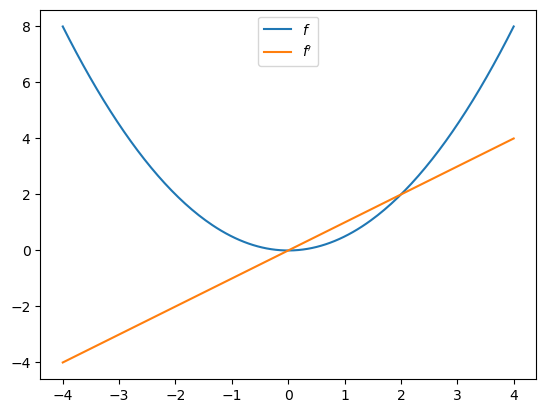

In [78]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x_grid = jnp.linspace(-4, 4, 200)
ax.plot(x_grid, f(x_grid), label="$f$")
ax.plot(x_grid, [f_prime(x) for x in x_grid], label="$f'$")
ax.legend(loc='upper center')
plt.show()

## Writing vectorized code

Writing fast JAX code requires shifting repetitive tasks from loops to array processing operations, so that the JAX compiler can easily understand the whole operation and generate more efficient machine code.

This procedure is called **vectorization** or **array programming**, and will be familiar to anyone who has used NumPy or MATLAB.

In some ways, vectorization is the same in JAX as it is in NumPy.

But there are also major differences, which we highlight here.

As a running example, consider the function

$$
    f(x,y) = \frac{\cos(x^2 + y^2)}{1 + x^2 + y^2}
$$

Suppose that we want to evaluate this function on a square grid of $x$ and $y$ points.


### A slow version with loops

To clarify, here is the slow `for` loop version, which we run in a setting where `len(x) = len(y)` is very small.

In [79]:
@jax.jit
def f(x, y):
    return jnp.cos(x**2 + y**2) / (1 + x**2 + y**2)

n = 80
x = jnp.linspace(-2, 2, n)
y = x

z_loops = np.empty((n, n))

In [80]:
%%time
for i in range(n):
    for j in range(n):
        z_loops[i, j] = f(x[i], y[j])

CPU times: user 4.08 s, sys: 1.26 s, total: 5.34 s
Wall time: 3.24 s


Even for this very small grid, the run time is extremely slow.

(Notice that we used a NumPy array for `z_loops` because we wanted to write to it.)

OK, so how can we do the same operation in vectorized form?

If you are new to vectorization, you might guess that we can simply write

In [81]:
z_bad = f(x, y)

But this gives us the wrong result because JAX doesn't understand the nested for loop.

In [82]:
z_bad.shape

(80,)

Here is what we actually wanted:

In [83]:
z_loops.shape

(80, 80)

### Vectorization attempt 1

To get the right shape and the correct nested for loop calculation, we can use a `meshgrid` operation that originated in MATLAB and was replicated in NumPy and then JAX:

In [84]:
x_mesh, y_mesh = jnp.meshgrid(x, y)

Now we get what we want and the execution time is very fast.

In [85]:
z_mesh = f(x_mesh, y_mesh) 

Let's confirm that we got the right answer.

In [86]:
jnp.allclose(z_mesh, z_loops)

Array(True, dtype=bool)

Now we can set up a serious grid and run the same calculation (on the larger grid) in a short amount of time.

In [87]:
n = 6000
x = jnp.linspace(-2, 2, n)
y = x
x_mesh, y_mesh = jnp.meshgrid(x, y)

In [88]:
%%time
z_mesh = f(x_mesh, y_mesh) 

CPU times: user 62.4 ms, sys: 198 µs, total: 62.6 ms
Wall time: 118 ms


In [89]:
%%time
z_mesh = f(x_mesh, y_mesh) 

CPU times: user 99 µs, sys: 19 µs, total: 118 µs
Wall time: 125 µs


But there is one problem here: the mesh grids use a lot of memory.

In [90]:
(x_mesh.nbytes + y_mesh.nbytes) / 1_000_000  # MB of memory

576.0

By comparison, the flat array `x` is just

In [91]:
x.nbytes / 1_000_000   # and y is just a pointer to x

0.048

This extra memory usage can be a big problem in actual research calculations.

In [92]:
del x_mesh  # Free memory
del y_mesh  # Free memory

### Vectorization attempt 2

We can achieve a similar effect through NumPy style broadcasting rules.

In [93]:
x_reshaped = jnp.reshape(x, (n, 1))   # Give x another dimension (column)
y_reshaped = jnp.reshape(y, (1, n))   # Give y another dimension (row)

When we evaluate $f$ on these reshaped arrays, we replicate the nested for loops in the original version.

In [94]:
%time z_reshaped = f(x_reshaped, y_reshaped)

CPU times: user 61.8 ms, sys: 84 µs, total: 61.9 ms
Wall time: 138 ms


In [95]:
%time z_reshaped = f(x_reshaped, y_reshaped)

CPU times: user 489 µs, sys: 93 µs, total: 582 µs
Wall time: 440 µs


Let's check that we got the same result

In [96]:
jnp.allclose(z_reshaped, z_mesh)

Array(True, dtype=bool)

The memory usage for the inputs is much more moderate.

In [97]:
(x_reshaped.nbytes + y_reshaped.nbytes) / 1_000_000

0.096

### Vectorization attempt 3


There's another approach to vectorization we can pursue, using [jax.vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html)

It runs out that, when we are working with complex functions and operations, this `vmap` approach can be the easiest to implement.

It's also very memory parsimonious.

The first step is to vectorize the function `f` in `y`.

In [98]:
f_vec_y = jax.vmap(f, in_axes=(None, 0))  

In the line above, `(None, 0)` indicates that we are vectorizing in the second argument, which is `y`.

Next, we vectorize in the first argument, which is `x`.

In [99]:
f_vec = jax.vmap(f_vec_y, in_axes=(0, None))

Finally, we JIT-compile the result:

In [100]:
f_vec = jax.jit(f_vec)

With this construction, we can now call the function $f$ on flat (low memory) arrays.

In [101]:
%%time
z_vmap = f_vec(x, y)

CPU times: user 69.1 ms, sys: 4.34 ms, total: 73.4 ms
Wall time: 133 ms


In [102]:
%%time
z_vmap = f_vec(x, y)

CPU times: user 322 µs, sys: 0 ns, total: 322 µs
Wall time: 317 µs


Let's check we produce the correct answer:

In [103]:
jnp.allclose(z_vmap, z_mesh)

Array(True, dtype=bool)

Let's finish by cleaning up.

In [104]:
del z_mesh
del z_vmap
del z_reshaped

### Exercises

**Exercise**

In a previous notebook we used Monte Carlo to price a European call option and
constructed a solution using Numba.

The code looked like this:

In [105]:
import numba
from numpy.random import randn
M = 10_000_000

n, β, K = 20, 0.99, 100
μ, ρ, ν, S0, h0 = 0.0001, 0.1, 0.001, 10, 0

@numba.jit(parallel=True)
def compute_call_price_parallel(β=β,
                                μ=μ,
                                S0=S0,
                                h0=h0,
                                K=K,
                                n=n,
                                ρ=ρ,
                                ν=ν,
                                M=M):
    current_sum = 0.0
    # For each sample path
    for m in numba.prange(M):
        s = np.log(S0)
        h = h0
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)
        
    return β**n * current_sum / M

Let's run it once to compile it:

In [106]:
compute_call_price_parallel()

171409.68191599599

And now let's time it:

In [107]:
%%time 
compute_call_price_parallel()

CPU times: user 19.8 s, sys: 0 ns, total: 19.8 s
Wall time: 1.15 s


141062.5730043863

Try writing a version of this operation for JAX, using all the same
parameters.

If you are running your code on a GPU, you should be able to achieve
significantly faster execution.

In [108]:
for i in range(12):
    print("Solution below.")

Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.


**Solution**

Here is one solution:

In [109]:
M = 10_000_000

n, β, K = 20, 0.99, 100
μ, ρ, ν, S0, h0 = 0.0001, 0.1, 0.001, 10, 0

@jax.jit
def compute_call_price_jax(β=β,
                           μ=μ,
                           S0=S0,
                           h0=h0,
                           K=K,
                           n=n,
                           ρ=ρ,
                           ν=ν,
                           M=M,
                           key=jax.random.PRNGKey(1)):

    s = jnp.full(M, np.log(S0))
    h = jnp.full(M, h0)
    for t in range(n):
        key, subkey = jax.random.split(key)
        Z = jax.random.normal(subkey, (2, M))
        s = s + μ + jnp.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
    expectation = jnp.mean(jnp.maximum(jnp.exp(s) - K, 0))
        
    return β**n * expectation

Let's run it once to compile it:

In [110]:
compute_call_price_jax()

2024-03-26 07:27:34.807821: W external/xla/xla/service/hlo_rematerialization.cc:2941] Can't reduce memory use below 5.55GiB (5959139320 bytes) by rematerialization; only reduced to 6.33GiB (6799998824 bytes), down from 6.56GiB (7040000024 bytes) originally
2024-03-26 07:27:47.390213: W external/tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.33GiB (rounded to 6800013056)requested by op 
2024-03-26 07:27:47.390405: W external/tsl/tsl/framework/bfc_allocator.cc:494] *_____*_____**_____*________________________________________________________________________________
E0326 07:27:47.391720  408251 pjrt_stream_executor_client.cc:2804] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6800012832 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         0B
              constant allocation:         0B
        maybe_live_out allocation:         8B
     pre

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6800012832 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         0B
              constant allocation:         0B
        maybe_live_out allocation:         8B
     preallocated temp allocation:    6.33GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    6.33GiB
              total fragmentation:    12.5KiB (0.00%)
Peak buffers:
	Buffer 1:
		Size: 152.59MiB
		Operator: op_name="jit(compute_call_price_jax)/jit(main)/jit(_normal)/jit(_normal_real)/erf_inv" source_file="/tmp/ipykernel_408251/3762069436.py" source_line=22
		XLA Label: fusion
		Shape: f64[2,10000000]
		==========================

	Buffer 2:
		Size: 152.59MiB
		Operator: op_name="jit(compute_call_price_jax)/jit(main)/jit(_normal)/jit(_normal_real)/erf_inv" source_file="/tmp/ipykernel_408251/3762069436.py" source_line=22
		XLA Label: fusion
		Shape: f64[2,10000000]
		==========================

	Buffer 3:
		Size: 152.59MiB
		Operator: op_name="jit(compute_call_price_jax)/jit(main)/jit(_normal)/jit(_normal_real)/erf_inv" source_file="/tmp/ipykernel_408251/3762069436.py" source_line=22
		XLA Label: fusion
		Shape: f64[2,10000000]
		==========================

	Buffer 4:
		Size: 152.59MiB
		Operator: op_name="jit(compute_call_price_jax)/jit(main)/jit(_normal)/jit(_normal_real)/erf_inv" source_file="/tmp/ipykernel_408251/3762069436.py" source_line=22
		XLA Label: fusion
		Shape: f64[20000000]
		==========================

	Buffer 5:
		Size: 152.59MiB
		Operator: op_name="jit(compute_call_price_jax)/jit(main)/jit(_normal)/jit(_normal_real)/erf_inv" source_file="/tmp/ipykernel_408251/3762069436.py" source_line=22
		XLA Label: fusion
		Shape: f64[2,10000000]
		==========================

	Buffer 6:
		Size: 152.59MiB
		Operator: op_name="jit(compute_call_price_jax)/jit(main)/jit(_normal)/jit(_normal_real)/erf_inv" source_file="/tmp/ipykernel_408251/3762069436.py" source_line=22
		XLA Label: fusion
		Shape: f64[2,10000000]
		==========================

	Buffer 7:
		Size: 152.59MiB
		Operator: op_name="jit(compute_call_price_jax)/jit(main)/jit(_normal)/jit(_normal_real)/erf_inv" source_file="/tmp/ipykernel_408251/3762069436.py" source_line=22
		XLA Label: fusion
		Shape: f64[2,10000000]
		==========================

	Buffer 8:
		Size: 152.59MiB
		Operator: op_name="jit(compute_call_price_jax)/jit(main)/jit(_normal)/jit(_normal_real)/erf_inv" source_file="/tmp/ipykernel_408251/3762069436.py" source_line=22
		XLA Label: fusion
		Shape: f64[20000000]
		==========================

	Buffer 9:
		Size: 152.59MiB
		Operator: op_name="jit(compute_call_price_jax)/jit(main)/jit(_normal)/jit(_normal_real)/erf_inv" source_file="/tmp/ipykernel_408251/3762069436.py" source_line=22
		XLA Label: fusion
		Shape: f64[2,10000000]
		==========================

	Buffer 10:
		Size: 152.59MiB
		Operator: op_name="jit(compute_call_price_jax)/jit(main)/jit(_normal)/jit(_normal_real)/erf_inv" source_file="/tmp/ipykernel_408251/3762069436.py" source_line=22
		XLA Label: fusion
		Shape: f64[2,10000000]
		==========================

	Buffer 11:
		Size: 152.59MiB
		Operator: op_name="jit(compute_call_price_jax)/jit(main)/jit(_normal)/jit(_normal_real)/erf_inv" source_file="/tmp/ipykernel_408251/3762069436.py" source_line=22
		XLA Label: fusion
		Shape: f64[2,10000000]
		==========================

	Buffer 12:
		Size: 152.59MiB
		Operator: op_name="jit(compute_call_price_jax)/jit(main)/jit(_normal)/jit(_normal_real)/erf_inv" source_file="/tmp/ipykernel_408251/3762069436.py" source_line=22
		XLA Label: fusion
		Shape: f64[20000000]
		==========================

	Buffer 13:
		Size: 152.59MiB
		Operator: op_name="jit(compute_call_price_jax)/jit(main)/jit(_normal)/jit(_normal_real)/erf_inv" source_file="/tmp/ipykernel_408251/3762069436.py" source_line=22
		XLA Label: fusion
		Shape: f64[2,10000000]
		==========================

	Buffer 14:
		Size: 152.59MiB
		Operator: op_name="jit(compute_call_price_jax)/jit(main)/jit(_normal)/jit(_normal_real)/erf_inv" source_file="/tmp/ipykernel_408251/3762069436.py" source_line=22
		XLA Label: fusion
		Shape: f64[2,10000000]
		==========================

	Buffer 15:
		Size: 152.59MiB
		Operator: op_name="jit(compute_call_price_jax)/jit(main)/jit(_normal)/jit(_normal_real)/erf_inv" source_file="/tmp/ipykernel_408251/3762069436.py" source_line=22
		XLA Label: fusion
		Shape: f64[2,10000000]
		==========================



And now let's time it:

In [ ]:
%%time 
compute_call_price_jax().block_until_ready()